## Point generator

Generate points based on the labels (taken as an input from the GUI)
structure of the point:
    (t0, vel, flag (1=hyperbolic, 0=linear), label)

In [1]:
import random
import numpy as np
import matplotlib.pylab as plt
from scipy import signal
from sklearn import svm
%matplotlib inline

In [2]:
def points_gen(nDA,nR,nCN,nMU):
    # The function generates random values of t0 - velocity pairs
    # based on number of requested waves:
    # nDA - number of direct waves (linear moveout, label 'D')
    # nR - number of reflections (hyperbolic moveout, label 'R')
    # nCN - number of coherent noise events (linear moveout, label 'N')
    # nMU - number of multiples (hyperbolic, label 'M')
    # outputs (nDA+nR+nCN) * (4) list
    # each point in the list has the following structure
    # [t0 (intercept time), velocity, flag(1=hyperbolic, 0=linear), label(see above))]
    
    
    # direct arrival
    direct = []
    for n in range(nDA):
        direct.append([random.uniform(0,.1),random.uniform(.5,1.5),0,'D'])
    
    reflected = []
    t0list = []
    for n in range(nR):
        t0 = random.uniform(0,3)
        reflected.append([t0, random.uniform(1.5,3.5), 1, 'R'])
        t0list.append(t0)
    
    multiples = []
    if len(reflected) > 0:
        for nmult in range(nMU):
            multiples.append([random.uniform(min(t0list),4), random.uniform(1.25,1.75), 1 , 'M'])
        
    noise = []
    for n in range(nCN):
        noise.append([random.uniform(-3,3),random.uniform(-3,3),0,'N'])
        
    
#    for n in range(nMU):
#        noise.append([random.uniform(random.uniform(2,2),4),random.uniform(1.5,2.5),1,'M'])

    events = direct + reflected + noise + multiples
    return events

## Convert points to data

Based on a point label, convert the point to t(x) series

In [3]:
def t_linear(x, v, t):
    # return a linear event (direct or coherent noise)
    return t + x/v

def t_reflected(x,v,t):
    return np.sqrt(t**2 + x**2 / v**2)

def points_to_data(events, dx = 0.005, xmax = 2):
    x = np.arange(0, xmax + dx, dx)
    t=[]
    labels = []
    
    for i in events:
        if i[3] == 'D' or i[3] == 'N':
            t.append(t_linear(x, i[1], i[0]))
            labels.append(i[3])
        if i[3] == 'R' or i[3] == 'M':
            t.append(t_reflected(x,i[1],i[0]))
            labels.append(i[3])
            
    return t, labels, x

## Make the data look like seismic

Transform the t(x) data into 2D matrix and then convolve with Ricker wavelet

In [4]:
def conv_ricker(array):
    points = 100
    a = 4.0
    ricker = signal.ricker(points, a)
    return np.convolve(array,ricker,mode='same')

def data_to_seism(data, x, dt = 0.01, tmax = 4):
    dataround = np.round(data,decimals=2)
    t = np.arange(0,tmax + dt,dt)
    
    datamatrix = np.zeros((len(t),len(x)))

    for event in dataround:
        for n, i in enumerate(event):
            idx = np.where((t >= i - 0.0001) & (t <= i + .0001))
            if np.size(idx[0]) != 0:
                #print(idx[0],n)
                datamatrix[idx[0][0]][n] = 1

    data_ricker = np.apply_along_axis(conv_ricker, 0, datamatrix)
    
    
    return data_ricker

# Visualiation

If flag == 1, mark with colors.

In [5]:
def data_plot(events, labels, x, colors = 'no'):
    
    seismic = data_to_seism(events, x)
    
    fig, ax = plt.subplots()
    ax.imshow(seismic, cmap='gray', interpolation='bicubic', extent=[0,2,4,0]);
    
    plt.ylabel('Time, s')
    plt.xlabel('Offset, km')
    
    if colors == 'yes':
        
    # plot waves with colors
        for n, event  in enumerate(events):
            if labels[n] == 'D':
                ax.plot(x,event,'r')
            if labels[n] == 'N':
                ax.plot(x,event,'b')
            if labels[n] == 'R':
                ax.plot(x,event,'g')
            if labels[n] == 'M':
                ax.plot(x,event,'y')
    ax.set_xlim([0,2])
    ax.set_ylim([0,4])
    ax.invert_yaxis()
    ax.set_aspect(1)
    return ax

## Test data used for model testing

In [6]:
# Generate points
# Inputs to the points_gen function are taken from GUI
events = points_gen(1,3,6,3)

# Convert generated points to data (t(x))
data, labels, x = points_to_data(events)

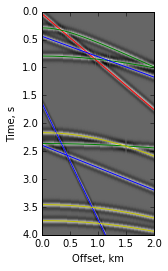

In [7]:
data_plot(data,labels,x,'yes')

## Prediction part:
1. Convert list of events to dictionary
2. Run SVM to obtain the model
3. Create "unseen" data and test the model
4. Calculate number of 'True' and 'False' predictions

In [8]:
#### A function that turns the events object lists of lists into a python dictionary
def makeEventsDict(events):
    eventsDict = {}
    labelsDict = {}
    # direct arrival
    labelsDict['label'] = []
    eventsDict['direct'], eventsDict['reflected'], eventsDict['coherentnoise'], eventsDict['multiples'] = [],[],[],[]
    eventsDict['events'] = []
    for each in events:
         eventsDict['events'].append(each[0:3])
         labelsDict['label'].append(each[3])
        
    return(eventsDict,labelsDict)

In [9]:
SVC = svm.SVC()
# This function takes a events list, turns it into two dictionaries combined, splits that into two arrays for X and Y
# trains a SVM label on them and then returns that model output details
# The model will need to be run on a input for a prediction

def comboFunctionA(events):
    testEvents = makeEventsDict(events)
    eventsDict = testEvents[0]
    labelsDict = testEvents[1]
    X = eventsDict['events']
#     print("X = ",X)
    y = labelsDict['label']
#     print("y = ",y)
    clf = svm.SVC()
    output = clf.fit(X, y)
    return(output)

In [10]:
def predict_from_data(events, model):
    labels = []
    for event in events:
        labels.append(model.predict([event[0:3]]))
    return labels

In [11]:
def examineModel(model):
    model_examine = {}
    model_examine['support_vectors_']= model.support_vectors_
    model_examine['support_']= model.support_
    model_examine['n_support_']= model.n_support_
    model_examine['model']= model
#     'support_':model.support_,'n_support_':model.n_support_}
    return(model_examine)

In [12]:
# A function that takes a model and an eventsDictionary and make predictions of labels for the eventsDictionary based on a trained model
def testUnseenEvents(model,eventsDict):
    score = {}
    score['result'] = []
    score['test'] = []
    score['isCorrect'] = []
    x = 0
#     eventsTest_eventsDict = eventsDict[0]['events']
#     eventsTest_labelsDict = eventsDict[1]['label']
    i = 0
    while i < len(eventsDict[0]['events']):
        each = i
#         print("each",each)
        eventsTest_eventsDict = eventsDict[0]['events']
        eventsTest_labelsDict = eventsDict[1]['label']
#         print("eventsTest_eventsDict",eventsTest_eventsDict)
#         print("eventsTest_labelsDict",eventsTest_labelsDict)
#         print("eventsTest_eventsDict[i]",eventsTest_eventsDict[i])
#         print("eventsTest_labelsDict[i]",eventsTest_labelsDict[i])
        prediction = model.predict([eventsTest_eventsDict[i]])
        if prediction == eventsDict[1]['label'][i]:
            isCorrect = "True"
        else:
            isCorrect = "False"
        score['result'].append(prediction)
        score['test'].append(each)
        score['isCorrect'].append(isCorrect)
        i += 1
    return(score)

In [13]:
def getTrueFalseOfPred(predictionDict):
    numberTrueFalse = {'True':0,'False':0,'PerTrue':0,'PerFalse':0,'Total':0}
    numberTrueFalse['Total'] = len(predictionDict['isCorrect'])
    i = 0
    while i < len(predictionDict['isCorrect']):
        if predictionDict['isCorrect'][i] == 'True':
            numberTrueFalse['True'] = numberTrueFalse['True'] + 1
        else:
            numberTrueFalse['False'] = numberTrueFalse['False'] + 1 
        i = i + 1
    numberTrueFalse['PerTrue'] = numberTrueFalse['True'] / numberTrueFalse['Total']
    numberTrueFalse['PerFalse'] = numberTrueFalse['False'] / numberTrueFalse['Total']
    return(numberTrueFalse)

In [14]:
# generate points for testing
events3 = points_gen(300,200,300,300)

events3_testEvents = makeEventsDict(events3)

In [15]:
answer = testUnseenEvents(events2Model,events3_testEvents)

NameError: name 'events2Model' is not defined

In [ ]:
getTrueFalseOfPred(answer)

## Actual prediction
1. Create model from a training dataset (large)
2. Predict labels for a test dataset (small)
3. Display seismic image:

    a. Without labeling (event classification)
    
    b. With correct labeling
    
    c. With predicted labeling

In [ ]:
# generate points for training
events2 = points_gen(200,200,200,200)

# make a model from training data
model = comboFunctionA(events2)

newLabels = predict_from_data(events, model)

data_plot(data,labels,x,'no')
data_plot(data,labels,x,'yes')
data_plot(data,newLabels,x,'yes')